In [1]:
import torch
%reset -f
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

import torch
import torch.optim as optim
import numpy as np
import os
import argparse
import time, datetime
import matplotlib
from src import config, data
from src.checkpoints import CheckpointIO
from collections import defaultdict
import shutil

In [2]:
cfg = config.load_config('configs/pointcloud/grid.yaml', 'configs/default.yaml')
is_cuda = (torch.cuda.is_available())
device = torch.device("cuda" if is_cuda else "cpu")

In [3]:
train_dataset = config.get_dataset("train", cfg)
ds = torch.utils.data.Subset(train_dataset, indices= [0]*len(train_dataset))
train_loader = torch.utils.data.DataLoader(
    ds, batch_size=1, num_workers=8, shuffle=True,
    collate_fn=data.collate_remove_none,
    worker_init_fn=data.worker_init_fn)

In [5]:
model = config.get_model(cfg, device=device, dataset=train_dataset)
model_dict = torch.load('out/pointcloud/grid/metropolis+surfaceCurlRegVeryLongbullshitModel_400000.pt') 

In [6]:
model.load_state_dict(model_dict['model'])

<All keys matched successfully>

In [7]:
def make_3d_grid(bb_min, bb_max, shape):
    ''' Makes a 3D grid.
    Args:
        bb_min (tuple): bounding box minimum
        bb_max (tuple): bounding box maximum
        shape (tuple): output shape
    '''
    size = shape[0] * shape[1] * shape[2]

    pxs = torch.linspace(bb_min[0], bb_max[0], shape[0])
    pys = torch.linspace(bb_min[1], bb_max[1], shape[1])
    pzs = torch.linspace(bb_min[2], bb_max[2], shape[2])

    pxs = pxs.view(-1, 1, 1).expand(*shape).contiguous().view(size)
    pys = pys.view(1, -1, 1).expand(*shape).contiguous().view(size)
    pzs = pzs.view(1, 1, -1).expand(*shape).contiguous().view(size)
    p = torch.stack([pxs, pys, pzs], dim=1)

    return p

In [8]:
voxel = make_3d_grid((0,-1,-1), (1,1,1), (32,)*3)

In [9]:
print(voxel.size())

torch.Size([32768, 3])


In [10]:
def eval_points(p, c=None, points_batch_size = 10000, vol_bound=None, **kwargs):
        ''' 
        Evaluates the occupancy values for the points.
        Args:
            p (tensor): points 
            c (tensor): encoded feature volumes
        '''
        p_split = torch.split(p, points_batch_size)
        occ_hats = []
        for pi in p_split: 
            pi = pi.unsqueeze(0).to(device)
            with torch.no_grad():
                occ_hat = model.decode(pi, c, **kwargs).logits
            occ_hats.append(occ_hat.squeeze(0).detach().cpu())
        
        occ_hat = torch.cat(occ_hats, dim=0)
        return occ_hat

In [14]:
batch = next(train_loader.__iter__())
inputs = batch.get('inputs').to(device)
voxel = make_3d_grid((-0.5,-0.5,0), (0.5,0.5,0.5), (32,)*3)
c = model.encode_inputs(inputs)
result = eval_points(p = voxel, c = c)

/home/nizar/miniconda3/envs/conv_onet/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [478]:
#gauss = torch.randn([1, 3000, 3], mean=(0.4,)*3).to(device)
dist = torch.distributions.Normal(torch.tensor([0.4]), torch.tensor([1.0]))
gauss=dist.sample()

In [412]:
m = torch.distributions.laplace.Laplace(torch.tensor([0.0]), torch.tensor([1.0]))
laplace = m.sample([1, 3000, 3])

In [469]:
gauss.shape

torch.Size([1, 3000, 3, 1])

<BarContainer object of 100 artists>

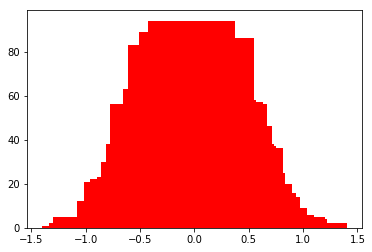

In [479]:
dist = torch.distributions.Normal(torch.tensor([0.8]), torch.tensor([10.0]))
gauss=dist.sample([3000])
hist = torch.histc(gauss)
x = torch.linspace(-1,1)
plt.bar(x, hist.cpu(), color=['red'])

In [345]:
result.size()

torch.Size([32768, 3])

In [118]:
import math

@torch.no_grad()
def sample(score_inputs, n_steps, epsilon, points_batch):
    sqrt_epsilon = math.sqrt(epsilon)
    points_batch.to(device)
    c = model.encode_inputs(score_inputs)
    kwargs={}
    
    for _ in range(n_steps):
        score = model.decode(points_batch, c, **kwargs).logits
        #score = -2*(points_batch)
        z = torch.randn_like(points_batch)
        points_batch = points_batch + 0.5 * epsilon * score#/torch.norm(score, dim=-1, keepdim=True) + sqrt_epsilon * z
    return points_batch

In [125]:
batch = next(train_loader.__iter__())
inputs = batch.get('inputs').to(device)
po = batch.get('inputs').to(device) 
points = po + 0.1*torch.randn_like(po)
moved_points = sample(inputs, 5000, 0.0001, points)

In [126]:
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

In [127]:
from mpl_toolkits.mplot3d import Axes3D
def plot_pointcloud(points, fig, title='', c = None):
    # Sample points uniformly from the surface of the mesh.
    x, y, z = points.clone().detach().cpu().squeeze().unbind(1)
    ax = Axes3D(fig)
    ax.scatter3D(x, z, -y, c = c)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_title(title)
    ax.view_init(190, 30)
    #plt.show()

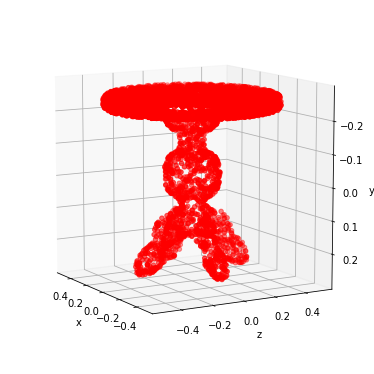

In [128]:
fig = plt.figure(figsize=(5, 5))
plot_pointcloud(po, fig, c='red')

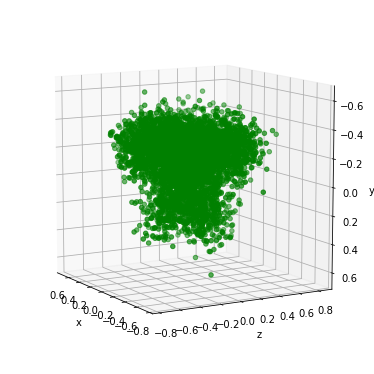

In [129]:
fig = plt.figure(figsize=(5, 5))

plot_pointcloud(points, fig, c='green')
#plot_pointcloud(moved_points, fig, c='red')

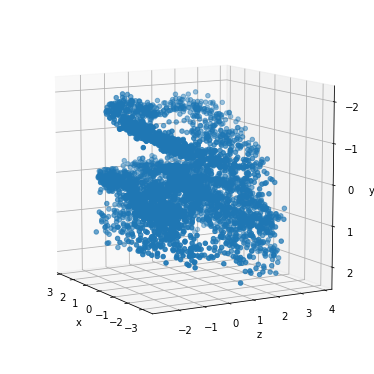

In [130]:
fig = plt.figure(figsize=(5, 5))

plot_pointcloud(moved_points, fig)

In [361]:
#torch to numpy station
resultnorm = torch.norm(result, dim=-1).numpy()
npvoxel = voxel.numpy()
npresult = result.numpy()

In [13]:
import numpy as np
import plotly.graph_objects as go

In [364]:
npvoxel.shape

(32768, 3)

In [14]:
resultnorm.max()

0.07166097

In [360]:
torch.randn(3000).max()

tensor(3.7880)

In [382]:
torch.randn(3000).numpy().shape

(3000,)

In [381]:
# Generate nicely looking random 3D-field
np.random.seed(0)

fig = go.Figure(data=go.Volume(
    x=torch.rand(3000).numpy(), y=torch.rand(3000).numpy(), z=torch.rand(3000).numpy(),
    value=torch.randn(3000).numpy(),
    isomin=-5,
    isomax=5,
    opacity=0.1,
    surface_count=50,
    ))
fig.update_layout(scene_xaxis_showticklabels=False,
                  scene_yaxis_showticklabels=False,
                  scene_zaxis_showticklabels=False)
fig.show()

In [376]:
# Generate nicely looking random 3D-field
np.random.seed(0)

print()
fig = go.Figure(data=go.Volume(
    x=torch.rand(3000).numpy(), y=torch.rand(3000).numpy(), z=torch.rand(3000).numpy(),
    value=torch.rand(3000).numpy(),
    isomin=-5,
    isomax=5,
    opacity=0.1,
    surface_count=50,
    ))
fig.update_layout(scene_xaxis_showticklabels=False,
                  scene_yaxis_showticklabels=False,
                  scene_zaxis_showticklabels=False)
fig.show()

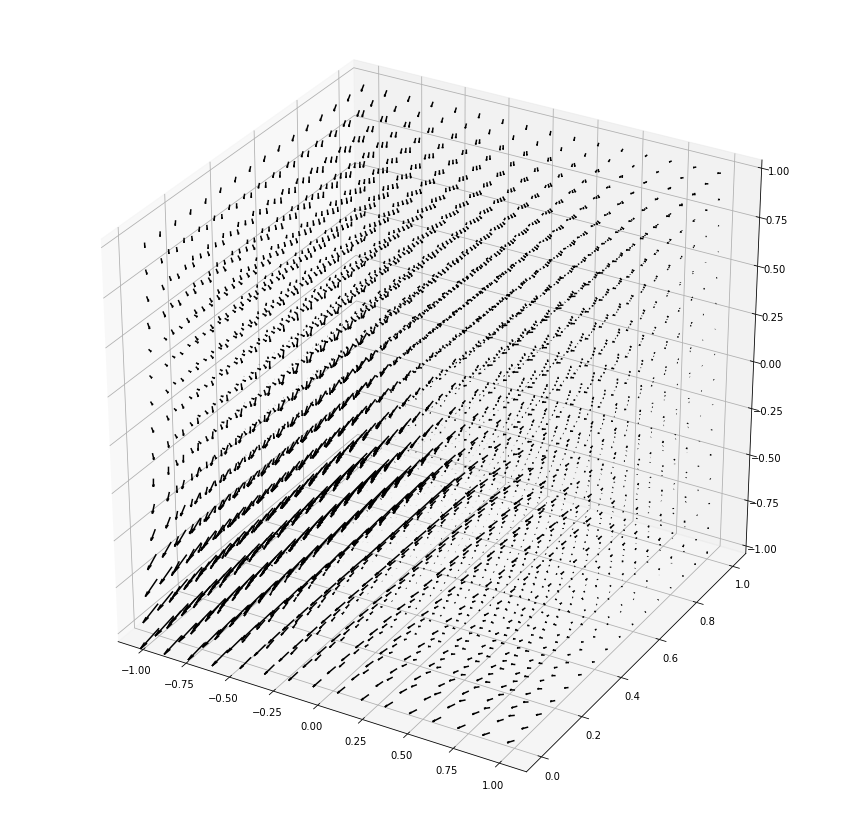

In [73]:

from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


fig = plt.figure(figsize=(15,15))
ax = fig.gca(projection='3d')


ax.quiver(npvoxel[:,0], npvoxel[:,1], npvoxel[:,2], npresult[:,0], npresult[:,1], npresult[:,2], length=0.2, color = 'black')

plt.show()


In [19]:
import math
@torch.no_grad()
def sample(score, n_samples, n_steps, epsilon, x=None):
    sqrt_epsilon = math.sqrt(epsilon)
    if x is None:
        # uniformly sample from the canvas
        x = torch.rand([n_samples, 3], device=self.device) * 2 - 1
    for _ in range(n_steps):
        z = torch.randn_like(x)
        x = x + 0.5 * epsilon * score(x) + sqrt_epsilon * z
    return x